# KAGGLE - TITANIC

This notebook tackles the Titanic Kaggle.

----

<a id='Summary'></a>

[0. Data & packages](#section0)

[1. Useful functions](#section1)

[2. Pre-processing](#section2)

[3. EDA & FE](#section3)

[4. Modeling & Evaluation](#section4)

----

<a id='section0'></a>
# 0. Data & packages
<a href='#Summary'>Haut de page</a>

In [64]:
import warnings

import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, make_scorer

import xgboost as xgb

import pickle


In [38]:
RANDOM_STATE = 42

In [39]:
df = pd.read_csv('./DATA/train.csv')

<a id='section1'></a>
# 1. Useful functions
<a href='#Summary'>Haut de page</a>

In [67]:
# Useful functions
def feature_names(sklearn_feature_name_output, df):
    """
    This function takes the output from the .get_feature_names() method on the PolynomialFeatures 
    instance and replaces values with df column names to return output such as 'Col_1 x Col_2'

    sklearn_feature_name_output: The list object returned when calling .get_feature_names() on the PolynomialFeatures object
    df: Pandas dataframe with correct column names
    """
    cols = df.columns.tolist()
    feat_map = {'x'+str(num):cat for num, cat in enumerate(cols)}
    feat_string = ','.join(sklearn_feature_name_output)
    for k,v in feat_map.items():
        feat_string = re.sub(fr"\b{k}\b",v,feat_string)
    return feat_string.replace(" "," x ").split(',')

def compute_score(clf, X, y):
    """
    This function evaluates clf on data by taking the mean of 5-fold CV
    """

    cval = cross_val_score(clf, X, y, cv = 5)

    return np.mean(cval)
    

<a id='section2'></a>
# 2. Pre-processing
<a href='#Summary'>Haut de page</a>

In [41]:
df.shape

(891, 12)

In [42]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [43]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [44]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [45]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [46]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

<a id='section3'></a>
# 3. EDA & FE
<a href='#Summary'>Haut de page</a>

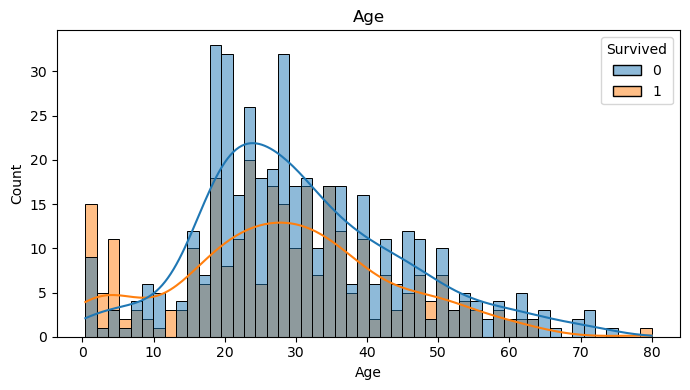

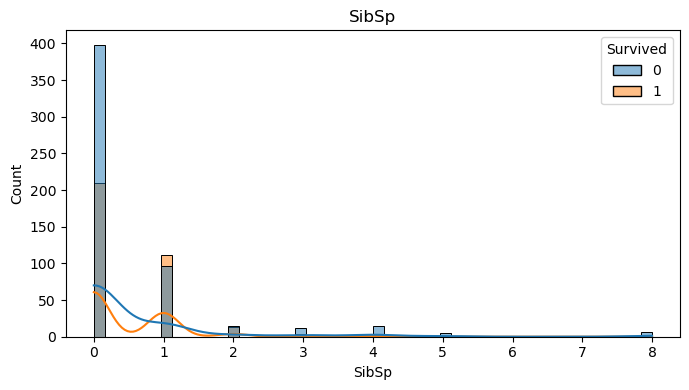

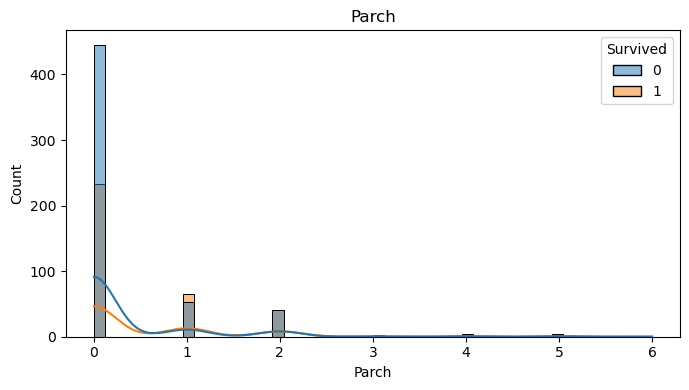

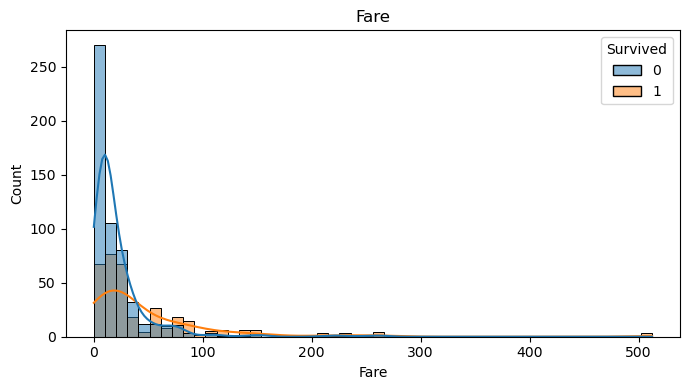

In [14]:
cols = ['Age', 'SibSp', 'Parch', 'Fare']

for x in cols:
    plt.figure(figsize=(7,4), dpi=100)
    sns.histplot(data=df, x=x, bins=50, kde=True, hue='Survived')
    plt.title(f"{x}")
    plt.tight_layout()

Text(0.5, 1.0, 'Correlation')

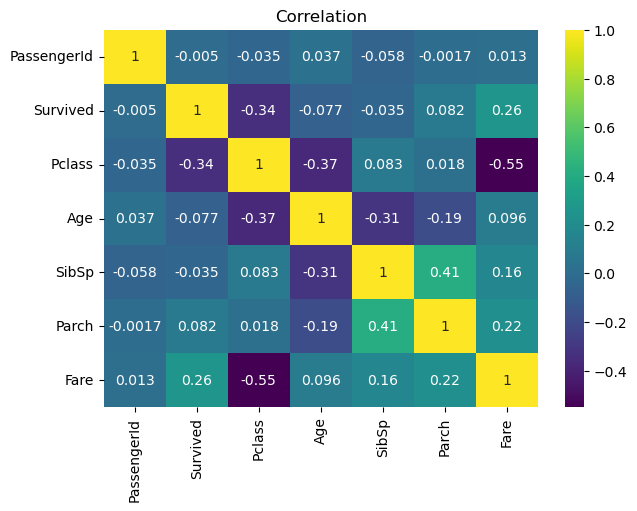

In [15]:
df_corr = df.corr()
plt.figure(figsize=(7,5), dpi=100)
sns.heatmap(data=df_corr, annot=True, cmap='viridis')
plt.title("Correlation")

<Figure size 1000x800 with 0 Axes>

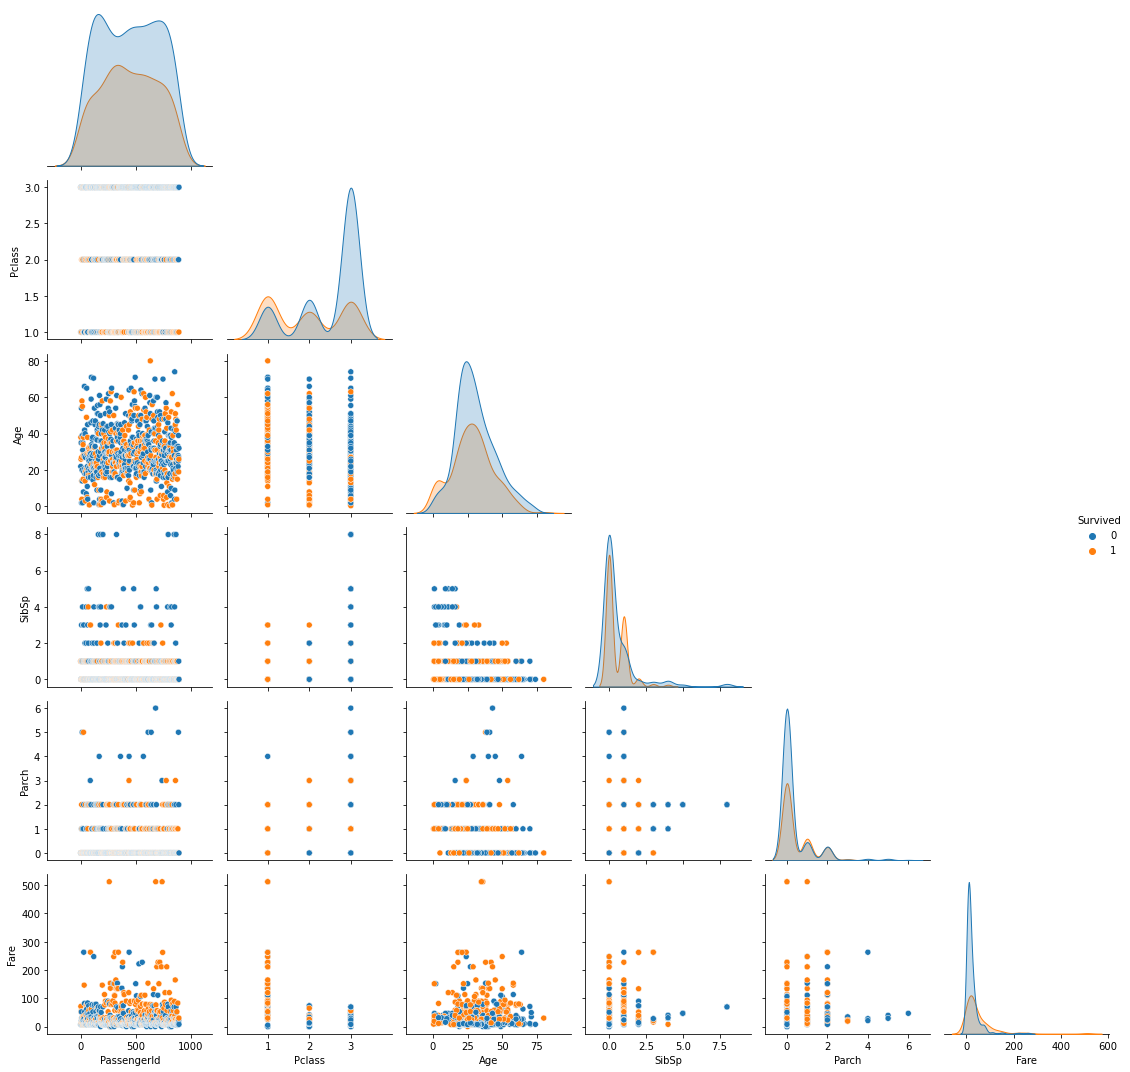

In [16]:
plt.figure(figsize=(10,8), dpi=100)
sns.pairplot(data = df, hue = "Survived", corner=True)
plt.tight_layout()

In [47]:
df.shape

(891, 12)

In [48]:
# Outliers
# df[(df.Fare > 500) | (df.Age > 75)]
df = df[(df.Fare <= 500) & ((df.Age <= 75) | df.Age.isnull())]

In [49]:
df.shape

(887, 12)

In [50]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          686
Embarked         2
dtype: int64

In [51]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
# Features

# df['Cabin_0'] = df['Cabin'].apply(lambda x : str(x)[0])
# df['Cabin_0'].value_counts()

# Group members for each passenger
df['group_members'] = df.groupby('Ticket')['Ticket'].transform('count')

# Family members
df['family_members'] = df['SibSp']+df['Parch']+1

# alone
df['alone'] = (df['family_members'] == 1).astype('category')

# NAs mask
df['age_na'] = df['Age'].isnull().astype('category')
df['embarked_na'] = df['Embarked'].isnull().astype('category')

# Title
df['title'] = df['Name'].apply(lambda x : x.split(', ')[-1].split('.')[0])

df.loc[df['title'] == 'Mlle', 'title'] = 'Miss'
df.loc[df['title'] == 'Ms', 'title'] = 'Miss'

df.loc[df['title'] == 'the Countess', 'title'] = 'Mrs'
df.loc[df['title'] == 'Lady', 'title'] = 'Mrs'
df.loc[df['title'] == 'Mme', 'title'] = 'Mrs'

df.loc[df['title'] == 'Major', 'title'] = 'Master'
df.loc[df['title'] == 'Col', 'title'] = 'Master'
df.loc[df['title'] == 'Capt', 'title'] = 'Master'
df.loc[df['title'] == 'Sir', 'title'] = 'Master'
df.loc[df['title'] == 'Don', 'title'] = 'Master'
df.loc[df['title'] == 'Jonkheer', 'title'] = 'Master'

In [53]:
df['title'].value_counts()

Mr        514
Miss      184
Mrs       128
Master     48
Dr          7
Rev         6
Name: title, dtype: int64

In [54]:
cat_cols = ['Sex', 'Embarked', 'Pclass', 'age_na', 'embarked_na', 'title', 'alone']
num_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'group_members', 'family_members']
features = cat_cols + num_cols
target = ['Survived']

df = df[features+target]

X = df.drop('Survived', axis=1)
y = df['Survived']

In [58]:
X.shape, y.shape

((665, 13), (222, 13))

In [59]:
X.head()

,Sex,Embarked,Pclass,age_na,embarked_na,title,alone,Age,SibSp,Parch,Fare,group_members,family_members
96,male,C,1,False,False,Mr,True,71.0,0,0,34.6542,1,1
344,male,S,2,False,False,Mr,True,36.0,0,0,13.0000,1,1
298,male,S,1,True,False,Mr,True,NaN,0,0,30.5000,1,1
652,male,S,3,False,False,Mr,True,21.0,0,0,8.4333,1,1
114,female,C,3,False,False,Miss,True,17.0,0,0,14.4583,2,1


In [60]:
X.isnull().sum()

Sex                 0
Embarked            2
Pclass              0
age_na              0
embarked_na         0
title               0
alone               0
Age               130
SibSp               0
Parch               0
Fare                0
group_members       0
family_members      0
dtype: int64

In [ ]:
# Imputation - cat
X['Embarked'] = X['Embarked'].fillna('S')

In [56]:
# Imputation - Num
strat_nan_num='mean'
#strat_nan_num='median'

quant_transformer = Pipeline(
    steps=[('Imputer', SimpleImputer(strategy = strat_nan_num))]) 

preprocessor_imp = ColumnTransformer(
    transformers=[('quant', quant_transformer, num_cols),],
    remainder='passthrough', verbose_feature_names_out=False)

X[num_cols] = preprocessor_imp.fit_transform(X[num_cols])

In [58]:
# OH encoding
categorical_transformer = Pipeline(
    steps=[('OHencoder', OneHotEncoder(handle_unknown='ignore', sparse=False, drop = 'first'))
    ])

preprocessor_oh = ColumnTransformer(
    transformers=[('cat', categorical_transformer, cat_cols)],
    remainder='passthrough', 
    verbose_feature_names_out=False)

In [59]:
X_oh = pd.DataFrame(preprocessor_oh.fit_transform(X), columns = preprocessor_oh.get_feature_names_out())

In [60]:
X = X_oh
X = X.set_index(y.index)

In [61]:
# Scaling
scaler = StandardScaler()

scaler.fit(X[num_cols])

X[num_cols] = scaler.transform(X[num_cols])

In [62]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Sex_male,887.0,6.471251e-01,0.478134,0.000000,0.000000,1.000000e+00,1.000000,1.000000
Embarked_Q,887.0,8.680947e-02,0.281715,0.000000,0.000000,0.000000e+00,0.000000,1.000000
Embarked_S,887.0,7.271702e-01,0.445665,0.000000,0.000000,1.000000e+00,1.000000,1.000000
Pclass_2,887.0,2.074408e-01,0.405703,0.000000,0.000000,0.000000e+00,0.000000,1.000000
Pclass_3,887.0,5.535513e-01,0.497404,0.000000,0.000000,1.000000e+00,1.000000,1.000000
age_na_True,887.0,1.995490e-01,0.399887,0.000000,0.000000,0.000000e+00,0.000000,1.000000
embarked_na_True,887.0,2.254791e-03,0.047458,0.000000,0.000000,0.000000e+00,0.000000,1.000000
title_Master,887.0,5.411499e-02,0.226372,0.000000,0.000000,0.000000e+00,0.000000,1.000000
title_Miss,887.0,2.074408e-01,0.405703,0.000000,0.000000,0.000000e+00,0.000000,1.000000
title_Mr,887.0,5.794814e-01,0.493921,0.000000,0.000000,1.000000e+00,1.000000,1.000000


In [492]:
# Polynomial features
cat_cols_oh = [col for col in X.columns if col not in num_cols]

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

In [493]:
X_num_poly = pd.DataFrame(poly.fit_transform(X[num_cols]), 
                          columns = feature_names(poly.get_feature_names_out(), X[num_cols]))

In [494]:
X = pd.concat([X[cat_cols_oh].reset_index(drop=True), X_num_poly.reset_index(drop=True)], axis=1)

In [495]:
X = X.set_index(y.index)

In [78]:
X.head().T

,96,344,298,652,114
Sex_male,1.000000,1.000000,1.000000,1.000000,0.000000
Embarked_Q,0.000000,0.000000,0.000000,0.000000,0.000000
Embarked_S,0.000000,1.000000,1.000000,1.000000,0.000000
Pclass_2,0.000000,1.000000,0.000000,0.000000,0.000000
Pclass_3,0.000000,0.000000,0.000000,1.000000,1.000000
age_na_True,0.000000,0.000000,1.000000,0.000000,0.000000
embarked_na_True,0.000000,0.000000,0.000000,0.000000,0.000000
title_Master,0.000000,0.000000,0.000000,0.000000,0.000000
title_Miss,0.000000,0.000000,0.000000,0.000000,1.000000
title_Mr,1.000000,1.000000,1.000000,1.000000,0.000000


<a id='section4'></a>
# 4. Modeling & evaluation
<a href='#Summary'>Haut de page</a>

In [71]:
X.to_pickle('./DATA/X.pkl')
y.to_pickle("./DATA/y.pkl")

HistGradientBoosting

In [ ]:
clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_iter=10000)

params = {'learning_rate' : [0.01, 0.1, 0.2],
          'l2_regularization' : [0, 0.01, 0.1, 0.2],
          "max_depth": [10, 15, 20]}

clf_grid = GridSearchCV(clf, 
                        param_grid = params,
                        verbose = 2)

clf_grid.fit(X, y)

In [72]:
clf_grid.best_estimator_.get_params()

{'categorical_features': None,
 'early_stopping': 'auto',
 'l2_regularization': 0,
 'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': 10,
 'max_iter': 10000,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 42,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [297]:
clf = HistGradientBoostingClassifier(loss = 'log_loss', 
                                     learning_rate = 0.01,
                                     l2_regularization = 0,
                                     max_depth = 10,
                                     random_state=RANDOM_STATE, max_iter=10000)
compute_score(clf, X, y)

HistGradientBoostingClassifier(l2_regularization=0, learning_rate=0.01,
                               max_depth=10, max_iter=10000, random_state=42)

In [298]:
y_pred = clf.predict(X_test)

Logistic regression

In [300]:
%%capture --no-display

clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)

params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

clf_grid = GridSearchCV(clf, 
                        param_grid = params,
                        scoring = 'balanced_accuracy',
                        verbose = 0)

clf_grid.fit(X, y)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='balanced_accuracy')

In [302]:
clf_grid.best_estimator_.get_params()

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'sag',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [74]:
clf = LogisticRegression(penalty = 'l2',
                         C = 1,
                         solver='sag', 
                         random_state=RANDOM_STATE, max_iter=10000)

compute_score(clf, X, y)

0.8207452548720878

GradientBoosting

In [85]:
clf = GradientBoostingClassifier(loss = 'deviance',
                                 learning_rate = 0.098,
                                 n_estimators = 460, 
                                 max_depth = 2, 
                                 min_samples_split = 9, 
                                 min_samples_leaf = 2,
                                 max_features = None,
                                 random_state = RANDOM_STATE)

compute_score(clf, X, y)

c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in v

0.8376690154256334

XGB

In [68]:
params = {'n_estimators': 250,
          'max_depth': 10,
          'learning_rate': 0.14411639396009357,
          'subsample': 0.55,
          'min_child_weight': 4.271886768987027,
          'colsample_bytree': 0.6,
          'reg_alpha': 0.18409122037935918,
          'reg_lambda': 0.6862290094219606}

clf = xgb.XGBClassifier(**params, 
                        seed = RANDOM_STATE)

compute_score(clf, X, y)

0.8455595759537866

Train on whole train data and export preprocessors and model

In [86]:
# # Imputation
# X['Embarked'] = X['Embarked'].fillna('S')
# X[num_cols] = preprocessor_imp.fit_transform(X[num_cols])

# # OH
# X_oh = pd.DataFrame(preprocessor_oh.fit_transform(X), columns = preprocessor_oh.get_feature_names_out())
# X = X_oh
# X = X.set_index(y.index)

# # Scaling
# X[num_cols] = scaler.fit_transform(X[num_cols])

# # Polynomial features

# # Training
# clf = GradientBoostingClassifier(loss = 'deviance',
#                                  learning_rate = 0.098,
#                                  n_estimators = 460, 
#                                  max_depth = 2, 
#                                  min_samples_split = 9, 
#                                  min_samples_leaf = 2,
#                                  max_features = None,
#                                  random_state = RANDOM_STATE)

clf.fit(X, y)

c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoostingClassifier(learning_rate=0.098, loss='deviance', max_depth=2,
                           min_samples_leaf=2, min_samples_split=9,
                           n_estimators=460, random_state=42)

In [87]:
filename = "OUTPUT/preprocessor_oh.pkl"
pickle.dump(preprocessor_oh, open(filename, 'wb'))

filename = "OUTPUT/preprocessor_imp.pkl"
pickle.dump(preprocessor_imp, open(filename, 'wb'))

filename = "OUTPUT/scaler.pkl"
pickle.dump(scaler, open(filename, 'wb'))

filename = "OUTPUT/clf.pkl"
pickle.dump(clf, open(filename, 'wb'))

Apply on test data

In [88]:
df = pd.read_csv('./DATA/test.csv')

In [89]:
# Features

# Group members for each passenger
df['group_members'] = df.groupby('Ticket')['Ticket'].transform('count')

# Family members
df['family_members'] = df['SibSp']+df['Parch']+1

# alone
df['alone'] = (df['family_members'] == 1).astype('category')

# NAs mask
df['age_na'] = df['Age'].isnull().astype('category')
df['embarked_na'] = df['Embarked'].isnull().astype('category')

# Title
df['title'] = df['Name'].apply(lambda x : x.split(', ')[-1].split('.')[0])

df.loc[df['title'] == 'Mlle', 'title'] = 'Miss'
df.loc[df['title'] == 'Ms', 'title'] = 'Miss'

df.loc[df['title'] == 'the Countess', 'title'] = 'Mrs'
df.loc[df['title'] == 'Lady', 'title'] = 'Mrs'
df.loc[df['title'] == 'Mme', 'title'] = 'Mrs'

df.loc[df['title'] == 'Major', 'title'] = 'Master'
df.loc[df['title'] == 'Col', 'title'] = 'Master'
df.loc[df['title'] == 'Capt', 'title'] = 'Master'
df.loc[df['title'] == 'Sir', 'title'] = 'Master'
df.loc[df['title'] == 'Don', 'title'] = 'Master'
df.loc[df['title'] == 'Jonkheer', 'title'] = 'Master'

In [90]:
cat_cols = ['Sex', 'Embarked', 'Pclass', 'age_na', 'embarked_na', 'title', 'alone']
num_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'group_members', 'family_members']
features = cat_cols + num_cols

X_test = df[features]

In [91]:
filename = "OUTPUT/preprocessor_oh.pkl"
preprocessor_oh = pickle.load(open(filename, 'rb'))

filename = "OUTPUT/preprocessor_imp.pkl"
preprocessor_imp = pickle.load(open(filename, 'rb'))

filename = "OUTPUT/scaler.pkl"
scaler = pickle.load(open(filename, 'rb'))

filename = "OUTPUT/clf.pkl"
clf = pickle.load(open(filename, 'rb'))

In [92]:
X_test[num_cols] = preprocessor_imp.transform(X_test[num_cols])

c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [93]:
X_test_oh = pd.DataFrame(preprocessor_oh.transform(X_test), columns = preprocessor_oh.get_feature_names_out())
X_test = X_test_oh

c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [94]:
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [95]:
y_pred = clf.predict(X_test)

Export test predictions

In [96]:
output = pd.DataFrame({'PassengerId': df['PassengerId'], 'Survived': y_pred})
output.to_csv('OUTPUT/submission.csv', index=False)